# 1. Giới thiệu chung

Huấn luyện model GAN là một việc không dễ dàng bởi trong quá trình huấn luyện model thường xuyên không thể hội tụ đến điểm cân bằng. Một trong những cách chúng ta có thể áp dụng để khắc phục sự không hội tụ đó là thay đổi hàm loss function. Trong bài viết này chúng ta sẽ cùng tìm hiểu phương pháp huấn luyện [Wasserstein GAN](https://arxiv.org/abs/1701.07875) và phạt WGAN-Gradient. Nếu đọc bài báo gốc bạn sẽ thấy hàm loss function của Wasserstein GAN có một chút khó hiểu bởi các lý thuyết khá hàn lâm và không dễ tiếp cận với người bắt đầu, nhưng trên thực tế việc áp dụng phương pháp này lại khá đơn giản. Nhằm đưa ra một lời giải thích một cách dễ hiểu kèm theo code mẫu, bài viết này mình sẽ làm rõ hơn về phương pháp Wasserstein GAN thông qua cách tiếp cận nắm vững lý thuyết. Qua đó bạn đọc sẽ hiểu được đặc trưng của các dạng hàm loss function khác nhau, ưu nhược điểm và trường hợp sử dụng của chúng. Đây sẽ là những kiến thức cơ bản nhưng là tiền đề quan trọng để chúng ta đi xa hơn để hiểu những nghiên cứu của thuật toán GAN SOTA và thậm chí là những lớp mô hình deep learning khác.

Nhưng trước khi bắt đầu bài viết này các bạn hãy ôn lại [Bài 43 - Model GAN](https://phamdinhkhanh.github.io/2020/07/13/GAN.html) để hiểu rõ kiến trúc và nguyên lý hoạt động của GAN. Sau khi đã hiểu GAN hoạt động như thế nào? Cách thức xây dựng và huấn luyện một mô hình GAN ra sao thì chúng ta sẽ quay lại đọc tiếp bài này. WGAN sẽ tập trung vào việc thay đổi hàm loss function. Do đó, đầu tiên chúng ta sẽ cùng phân tích các dạng loss function được sử dụng chung trong các model GAN và đơn giản nhất là hàm cross entropy bên dưới.


# 2. Cross Entropy

Chúng ta đã biết trong hồi qui logistic và softmax sử dụng loss function là hàm _cross entropy_ để đo lường **tương quan** giữa 2 phân phối xác suất thực tế $\mathbf{p} = (p_1, \dots, p_C)$ và phân phối xác suất dự báo $\mathbf{q} = (q_1, \dots, q_C)$ như sau:

$$D_{CE}(\mathbf{p} \Vert \mathbf{q}) \triangleq \mathbf{H}(\mathbf{p}, \mathbf{q}) = -\sum_{i=1}^{C}p_i\log({q_i})$$

Trong đó $\sum_{i=1}^{C} p_i = \sum_{i=1}^{C} q_i = 1$ và $C$ là số lượng classes. $\mathbf{H}(\mathbf{p}, \mathbf{q})$ chính là ký hiệu của hàm _cross entropy_ của hai phân phối $\mathbf{p}$ và $\mathbf{q}$.

Mục tiêu tối ưu hóa hàm loss function cũng đồng nghĩa với mục tiêu tìm ra mô hình dự báo phân phối $\mathbf{q}$ **sát nhất** với phân phối $\mathbf{p}$. Hai nói cách khác, khi phân phối $\mathbf{p}$ và $\mathbf{q}$ càng tương quan thì giá trị hàm _cross entropy_ càng nhỏ và mô hình dự báo càng chuẩn xác. Trái lại khi $\mathbf{p}$ và $\mathbf{q}$ không tương quan thì giá trị của _cross entropy_ càng lớn.

Thật vậy, để dễ hình dung chúng ta lấy ví dụ trong trường hợp phân loại nhị phân, nhãn $p_i$ sẽ nhận một trong hai giá trị $\{ 0, 1 \}$. Ta có: $D_{CE}(\mathbf{p} \Vert \mathbf{q}) = -log({q_i})$ (trường hợp $p_i = 0$ thì đóng góp vào cross entropy bằng 0, trường hợp $p_i = 1$ ta thu được công thức như trên). Khi đó đồ thị của hàm _cross entropy_ biểu diễn theo $q_i$ như sau:


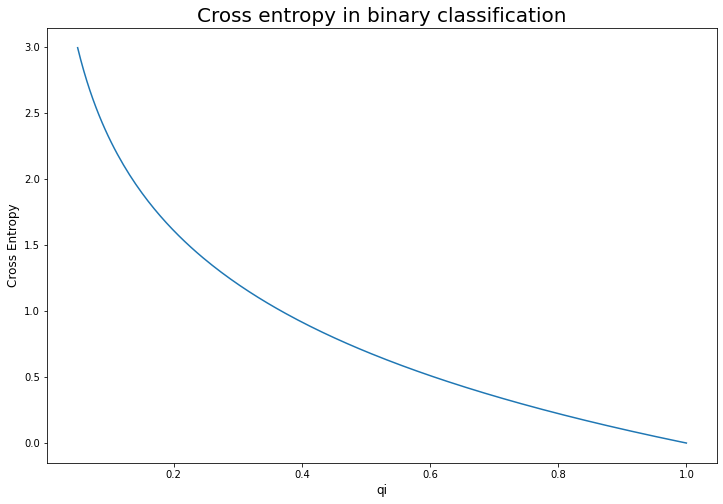

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

q = np.linspace(0.05, 1, 200)
d_ce = -np.log(q)

plt.figure(figsize=(12, 8))
plt.plot(q, d_ce)
plt.ylabel('Cross Entropy', fontsize=12)
plt.xlabel('qi', fontsize=12)
plt.title('Cross entropy in binary classification', fontsize=20)
plt.show()

Ta có thể thấy gía trị nhỏ nhất của hàm _cross entropy_ đạt được khi $q_i=1$. Tức là phân phối xác suất của $\mathbf{p}$ và $\mathbf{q}$ là trùng nhau. Trong trường hợp tổng quát cho nhiều nhãn ta cũng có thể chứng minh được sự **tương quan** giữa $\mathbf{p}$ và $\mathbf{q}$ tại điểm cực tiểu của _cross entropy_. Bài toán tối ưu _cross entropy_ có dạng như sau:

$$(\mathbf{p}^*, \mathbf{q}^*) = \arg \min_{(\mathbf{p}, \mathbf{q})} \mathbf{H}(\mathbf{p}, \mathbf{q}) = \arg \min_{(\mathbf{p}, \mathbf{q})} -\sum_{i=1}^{C}p_i\log({q_i})$$

Thỏa mãn ĐK: $\sum_{i=1}^{C} p_i = \sum_{i=1}^{C} q_i = 1$.

Đây là bài toán tối ưu lồi với điều kiện ràng buộc tuyến tính nên các giải quen thuộc là thông qua tối ưu hàm lagrange:

$$\mathcal{L}(\mathbf{p}, \mathbf{q}, \lambda) = -\sum_{i=1}^{C}p_i\log({q_i}) + \lambda (\sum_{i=1}^{C} q_i - 1)$$

Nếu coi phân phối $\mathbf{p}$ là cố định và tìm phân phối $\mathbf{q}$ theo $\mathbf{p}$ để tối thiểu hóa hàm lagranage. Các phương trình đạo hàm bậc nhất của hàm lagrange như sau:

$$
\left\{
\begin{matrix}
    \nabla_{q_i} \mathcal{L}(\mathbf{p}, \mathbf{q}, \lambda) &=& - {\frac{p_i}{q_i}} + \lambda~~~ &, \forall i=\overline{1, C} ~~~ \\
    \nabla_{\lambda} \mathcal{L}(\mathbf{p}, \mathbf{q}, \lambda) &=& \sum_{i=1}^{C} q_i - 1 & ~~~ 
\end{matrix}
\right.$$

Điều kiện cần để bài toán có cực trị đó là đạo hàm bậc nhất có nghiệm bằng 0. Tức là: $\frac{p_1}{q_1} = \frac{p_2}{q_2} = \dots = \frac{p_C}{q_C} = \lambda$. Suy ra cực trị đạt được khi $\mathbf{p}$ và $\mathbf{q}$ có cùng phân phối xác suất.

Mặc khác $$\nabla_{q_i}^2 \mathcal{L}(\mathbf{p}, \mathbf{q}, \lambda) = \frac{p_i}{q_i^2} \geq 0, \forall i=\overline{1, C}$$
nên hàm mục tiêu là một hàm lồi. Do đó đây chính là điều kiện đủ để cực trị $(\mathbf{p}^*, \mathbf{q}^*)$ đạt được chính là điểm cực tiểu.

Chứng minh bài toán không quá khó phải không nào? 

Như vậy tìm cực tiểu của _cross entropy_ chính là tìm các giá trị để phân phối dự báo sát với phân phối thực tế nhất. Đó cũng là lý do _cross entropy_ thường được lựa chọn làm hàm mục tiêu trong các bài toán liên quan tới dự báo phân phối xác suất.

# 3. Kullback Leibler divergence

_cross entropy_ là một độ đo được sử dụng phổ biến trong các bài toán phân loại thuộc lớp các bài toán học có giám sát. Tuy nhiên _cross entropy_ có một số hạn chế đó là giá trị của nó có thể lớn tùy ý. Chẳng hạn như khi $p_i = q_i = \frac{1}{n}, i \in \forall \bar{1,n}$. Khi $n \rightarrow +\infty$ thì giá trị của _cross entropy_ sẽ là :

$$\lim_{n \rightarrow +\infty} D_{CE}(\mathbf{p} \Vert \mathbf{q}) = \lim_{n \rightarrow +\infty}-\sum_{i=1}^{n}\frac{1}{n}\log(\frac{1}{n}) = \lim_{n \rightarrow \infty} log({n}) = +\infty$$

Do đó giá trị của _cross entropy_ có thể đưa ra giá trị _tương quan_ giữa hai phân phối $\mathbf{p}$ và $\mathbf{q}$ là một số rất lớn mặc dù chúng thể hiện cùng một phân phối xác suất. Tồn tại một thước đo khác giúp tìm ra khác biệt giữa hai phân phối xác suất $P(x), Q(x)$ và trả về giá trị là $0$ trong trường hợp hai phân phối này là trùng nhau. Đó chính là độ đo _Kullback leiber divergence_ như sau:

$$\begin {eqnarray}D_{KL}(P \Vert Q) & = & \sum_{i=1}^{n}P(x)\log({\frac{P(x)}{Q(x)}}) \\
& = & \sum_{i=1}^{n}P(x)[\log(P(x)) - \log(Q(x))]  \tag{1}
\end {eqnarray}$$

Công thức trên là xét với trường hợp phân phối của $x$ rời rạc. Nếu phân phối của $x$ liên tục thì tổng sẽ được chuyển sang tích phân:

$$D_{KL}(p \Vert q) = \int_{\chi} p(x)\log({\frac{p(x)}{q(x)}}) dx$$

Với $\chi$ là miền xác định của $x$. Các ký hiệu chữ thường $p, q$ đại diện cho _hàm mật độ xác suất (pdf)_ của biến liên tục $x$. Nếu bạn vẫn chưa biết _hàm mật độ xác suất_ là gì hãy xem lại [Apenddix 1 - Lý thuyết phân phối và kiểm định thống kê](https://phamdinhkhanh.github.io/2019/05/10/Hypothesis_Statistic.html#21-kh%C3%A1i-ni%E1%BB%87m-bi%E1%BA%BFn-ng%E1%BA%ABu-nhi%C3%AAn). 

Hàm $D_{KL}(p \Vert q)$ rõ ràng không xác định tại một số trường hợp đặc biệt khi $p(x) = 0$ hoặc $q(x) = 0$. Khi đó chúng ta phải qui ước giá trị của nó tại những điểm đặc biệt này. Cụ thể: 

Tại $p(x) = 0$ thì $p(x)\log(p(x)) = 0$, nó không có đóng góp gì vào độ lớn của hàm số $D_{KL}(p \Vert q)$.

Trường hợp $q(x)=0$, $p(x)$ hữu hạn thì ta coi $\log(q(x)) \rightarrow -\infty$, suy ra:
$$D_{KL}(p \Vert q) = +\infty \tag{2}$$
Ngoài ra ta nhận thấy một tính chất đặc biệt đó là phương trình (1) tương đương với:

$$D_{KL}(P \Vert Q) = \mathbf{H}(P, Q)-\mathbf{H}(P)$$

Trong đó $\mathbf{H}(P) = -P(x) \log P(x)$ chính là hàm _entropy_ đo lường giá trị trung bình của $\log(P(x))$ theo phân phối $P(x)$. Đây là hàm số thường được sử dụng để đánh giá mức độ tinh khiết của chỉ một phân phối xác suất (tinh khiết được hiểu là output trả ra chỉ thuộc về một nhóm) và thường được dùng trong các thuật toán về decision tree. 

Hàm _cross entropy_ $\mathbf{H}(P, Q)$ đo lường giá trị trung bình của $\log(Q(x))$ theo phân phối $P(x)$. 

Như vậy, khoảng cách $D_{KL}(P \Vert Q)$ là một thước đo giá trị khác biệt giữa hai phân phối $P(x)$ và $Q(x)$. Giá trị của $D_{KL}$ sẽ bằng 0 khi $P(x)$ và $Q(x)$ có phân phối trùng nhau. Ta chứng minh điều này như sau: 

**Tìm cực trị của $D_{KL}(P \Vert Q)$**

Giả sử giá trị của hai phân phối là: $P = (p_1, \dots, p_C)$ và $Q = (q_1, \dots, q_C)$. 

Trong trường hợp tồn tại $q_j=0$ thì theo như qui ước ở $(2)$ ta có $D_{KL}(p \Vert q) = +\infty$.

Xét hàm số:
$$f(x) = -\log(x)$$

Trên miền xác định $x > 0$. Ta có :
$$
\left\{
\begin{matrix}
    \nabla_x{f(x)} & = & \frac{-1}{x}\\
    \nabla_x^2{f(x)} & = & \frac{1}{x^2} > 0 & ~~~ 
\end{matrix}
\right.$$

Như vậy $f(x)$ là một hàm lồi ngặt trên toàn miền $x \in (0, 1]$. Do đó nó thỏa mãn bất đẳng thức [Jensen](https://en.wikipedia.org/wiki/Jensen%27s_inequality) đối với hàm lồi:
$$\lambda f(x_1) + (1-\lambda) f(x_2) \geq f(\lambda x_1 + (1-\lambda) x_2)$$ 
với mọi $\lambda \in (0, 1]$

Trong trường hợp tổng quát ta có:

$$\sum_{i=1}^{n}\lambda_i f(x_i) \geq f(\sum_{i=1}^{n}\lambda_i x_i)$$

Với $\sum_{i=1}^{n} \lambda_i = 1$ và $\lambda_i \in (0, 1] ~~~, \forall i= \overline{1, n}$

Áp dụng bất đẳng thức đối với hàm lồi ta có :

$$\begin {eqnarray} D_{KL}(P \Vert Q) & = & - \sum_{i=1}^{C} p_i \log(\frac{q_i}{p_i}) \\
& = & \sum_{i=1}^{C} p_if(\frac{q_i}{p_i}) \geq f(\sum_{i=1}^{C}p_i\frac{q_i}{p_i}) \\
& = & \log(\sum_{i=1}^{C}q_i)=\log(1) = 0 \end{eqnarray}$$

Như vậy giá trị của $D_{KL}(P \Vert Q)$ nhỏ nhất bằng 0 trên toàn miền $(0, 1]$. Kết hợp với trường hợp tồn tại $q_i = 0$ thì $D_{KL}(p \Vert q) = +\infty$ ta suy ra giá trị nhỏ nhất là 0 đại được trên toàn miền $[0, 1]$. Vì $f(x)$ là một hàm lồi ngặt (_strictly convex_) nên đẳng thức đạt được khi:

$$\frac{q_1}{p_1} = \frac{q_2}{p_2} = \dots = \frac{q_C}{p_C} = \lambda$$

Tức là phân phối $P$ và $Q$ là đồng nhất.

Như vậy _Kullback Leibler divergence_ là một hàm số sát hơn đo lường khoảng giữa hai phân phối. So với cross entropy thì giá trị của nó nhỏ hơn và đặc biệt khi hai phân phối trùng nhau thì khoảng cách _Kullback Leibler divergence_ đạt giá trị cực tiểu và bằng 0.



## 3.1. Ví dụ về độ đo Kullback Leibler divergence

Để hiểu rõ hơn về đặc tính đo lường sự khác biệt giữa hai phân phối xác suất của _Kullback Leibler divergence_ chúng ta cùng lấy ví dụ về ba phân phối xác suất $p$, $q$ và $y$ cùng được tạo ra từ phân phối chuẩn theo công thức:

$$\text{pdf}(x) = \frac{\exp {\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi \sigma^2}}$$

Trong đó phân phối của $y \sim \mathbf{N}(0, 1)$, $p \sim \mathbf{N}(0.1, 1)$ và $q \sim \mathbf{N}(2, 1)$.


Ta nhận thấy cả ba phân phối này có cùng phương sai, tuy nhiên tâm của phân phối chính là giá trị kỳ vọng của các phân phối của $p$ lại gần với $y$ hơn so với $q$ nên khả năng cao phân phối $p$ sẽ giống $y$ hơn phân phối $q$. Chúng ta cùng kiểm chứng thông qua mô phỏng các phân phối này:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y = np.random.uniform(0, 1, 200)
p = np.random.uniform(0.1, 1, 200)
q = np.random.uniform(2, 1, 200)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


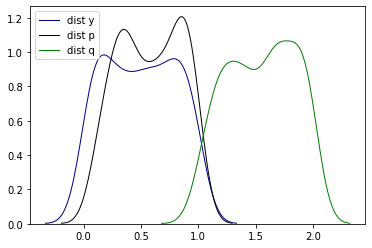

In [ ]:
import seaborn as sns
sns.distplot(y, 
             hist = False, 
             kde = True,
             color = 'darkblue', 
             kde_kws={'linewidth':1},
             label = 'dist y'
             )

sns.distplot(p, 
             hist = False, 
             kde = True,
             color = 'black', 
             kde_kws={'linewidth':1},
             label = 'dist p'
             )

sns.distplot(q, 
             hist = False, 
             kde = True,
             color = 'green', 
             kde_kws={'linewidth':1},
             label = 'dist q'
             )

plt.show()

Đồng thời áp dụng công thức (1) để tính khoảng cách giữa các phân phối theo độ đo Kullback Leibler ta có:

In [ ]:
def kl(p, q):
  return np.sum(p*np.log(p/q))

kl_py = kl(p, y)
kl_qy = kl(q, y)

print('Kullback leibler (p, y): ', kl_py)
print('Kullback leibler (q, y): ', kl_qy)

Kullback leibler (p, y):  69.72425099387095
Kullback leibler (q, y):  459.4113963613252


Kết quả cho thấy khoảng cách $D_{KL}(p \Vert y) \leq D_{KL}(q \Vert y)$. Kết quả này cho thấy nhận định về độ đo _Kullback Leibler_ đo lường khoảng cách giữa 2 phân phối là hoàn toàn phù hợp.

Mặc dù _Kullback Leibler_ trông có vẻ khá hoàn hảo nhưng nó cũng tồn tại những hạn chế khiến cho nó không phù hợp với một phép đo khoảng cách đó là không có tính chất đối xứng và giá trị không bị chặn khiến cho chúng ta phải tìm đến một độ đo mới khắc phục được cả hai nhược điểm này. Đó chính là Jensen-Shannon.

# 4. Jensen-Shannon


Jensen-Shannon là độ đo được xây dựng dựa trên Kullback Leibler

$$D_{JS}(P \Vert Q) = D_{KL}(P \Vert \frac{P+Q}{2}) + D_{KL}(Q \Vert \frac{P+Q}{2})$$

Độ đo Jensen-Shannon thay vì đo khoảng cách trực tiếp giữa $P$ và $Q$ thì nó đo khoảng cách này thông qua $P$ với $\frac{P+Q}{2}$ và $Q$ với $\frac{P+Q}{2}$. Ở đây $\frac{P+Q}{2}$ là phân phối trung bình của hai phân phối $P$ và $Q$. Nếu $P$ và $Q$ càng giống nhau thì khoảng cách của nó tới phân phối trung bình càng nhỏ.

Một tính chất quan trọng của Jensen-Shannon so với Kullback Leibler đó là nó có tính chất đối xứng. Nghĩa là : $D_{JS}(P \Vert Q) = D_{JS}(Q \Vert P)$. Ngoài ra, khai triển Jensen-Shannon ta có:

$$\begin {eqnarray}D_{JS}(P \Vert Q) & = & \sum_{i=1}^{C} P(x) \log(P(x)) - \sum_{i=1}^{C} P(x) \log(\frac{P(x)+Q(x)}{2}) \\
& + & \sum_{i=1}^{C} Q(x) \log(Q(x)) - \sum_{i=1}^{C} Q(x) \log(\frac{P(x)+Q(x)}{2}) \\
& = & - \sum_{i=1}^{C} (P(x)+Q(X)) \log(\frac{P(x)+Q(x)}{2}) + \sum_{i=1}^{C} P(x) \log(P(x)) + \sum_{i=1}^{C} Q(x) \log(Q(x))\\
& = & 2.\mathbf{H}(\frac{P+Q}{2}) - \mathbf{H}(P) - \mathbf{H}(Q) \\
\end {eqnarray}$$

Jensen-Shannon sẽ bằng hiệu giữa _entropy_ của phân phối trung bình $\frac{P+Q}{2}$ với các _entropy_ của $P$ và $Q$.

Ta nhận thấy độ đo Kullback-Leiber sẽ rất lớn tại những điểm $x$ mà giá trị của $Q(x)$ rất nhỏ và giá trị của $P(x)$ khác 0. Bởi vì khi đó $\log(\frac{P(x)}{Q(x)}) \rightarrow +\infty$. Do đó hàm loss function sẽ thường không hội tụ nếu xuất hiện những điểm $x$ mà phân phối của $Q(x) \rightarrow 0^+$.

![](https://imgur.com/IDrIpcZ.png)

**Hình 1:** Giá trị của Kullback-Leibler tại những điểm có $Q(x) \rightarrow 0^+$ sẽ khiến cho $D_{KL}(P \Vert Q) \rightarrow +\infty$.

Độ đo Jensen-Shannon sẽ khắc phục được những hiện tượng này vì giá trị của $\log(\frac{P(x)}{P(x)+Q(x)})$ luôn giao động trong khoảng:

$$\log(\frac{P(x)}{P(x)+1}) \leq \log(\frac{P(x)}{P(x)+Q(x)}) \leq 1$$

Do đó 

$$D_{KL}(P \Vert \frac{P+Q}{2}) = P(x)\log(\frac{P(x)}{P(x)+Q(x)}) \leq P(x)$$


Điều đó đảm bảo đóng góp vào khoảng cách $D_{JS}(P \Vert Q)$ tại mọi điểm $x$ luôn không bị giới hạn trên và không làm giá trị khoảng cách trở nên quá lớn. Đây chính là ưu điểm chính của độ đo Jensen-Shannon so với Kullback-Leibler.



## 4.1. Hội tụ của GAN và khoảng cách Jensen-Shannon

Ta sẽ chứng minh rằng hội tụ của GAN sẽ chính là hội khoảng cách Jensen-Shannon. Ở [bài 43](https://phamdinhkhanh.github.io/2020/07/13/GAN.html) ta đã biết hàm loss function của GAN là kết hợp giữa generator và discriminator có dạng như sau :

$$\min_{G} \max_{D} V(D, G) = \mathbb{E}_{x \sim p_r(x)} [\log (D(x))] +  \mathbb{E}_{z \sim p_z(z)} [\log(1-D(G(z)))]$$

Ở đây $x \sim p_r(x)$ là phân phối của dữ liệu thật và $z \sim p_z(z)$ là phân phối của dữ liệu sinh.

Khi mô hình GAN hội tụ thì $G(z) \rightarrow x$, tức là dữ liệu sinh ra giống với dữ liệu thật nhất. Như vậy tại điểm hội tụ của mô hình generator $G^*$ ta có thể thay thế  $G(z)$ bằng hội tụ $x$ của nó. Khi đó giá trị hội tụ của loss function sẽ là:

$$\max_{D} V(D, G^*) = \mathbb{E}_{x \sim p_r(x)} [\log (D(x))] +  \mathbb{E}_{x \sim p_g(x)} [\log(1-D(x))]$$

$x \sim p_g(x)$ là phân phối của dữ liệu từ mô hình generator. Mặt khác ta có tính chất :

$$\mathbb{E}_{x \sim p(x)} f(x) = \int_x p(x)f(x)dx$$

Do đó:

$$\begin{eqnarray}
\max_{D} V(D, G^*) & = & \mathbb{E}_{x \sim p_r(x)} [\log (D(x))] +  \mathbb{E}_{x \sim p_g(x)} [\log(1-D(x))] \\
& = & \int_x p_r(x)\log (D(x))dx + \int_x p_g(x)\log (1-D(x))dx \\
& = & \int_x p_r(x)\log (D(x)) + p_g(x)\log (1-D(x)) dx
\end{eqnarray}$$

Mục tiêu của chúng ta là tìm kiếm discriminator để tối đa hóa giá trị của hàm loss function nên $D(x)$ được xem như biến của bài toán cực trị. Đặt $D(x) = y$.

Xét hàm $$v(y) = p_r(x)\log (y) + p_g(x)\log (1-y)$$

Hàm số trên có đạo hàm bậc nhất và bậc 2 :

$$
\left\{
\begin{matrix}
    \nabla_y{} v(y) & = & \frac{p_r(x)}{y}-\frac{p_g(x)}{1-y}\\
    \nabla_y^2{f(x)} & = & -\frac{p_r(x)}{y^2} - \frac{p_g(x)}{(1-y)^2} < 0 & ~~~ 
\end{matrix}
\right.$$

Như vậy $v(y)$ là một hàm lõm. Do đó giá trị cực đại của nó chính là nghiệm của phương trình đạo hàm bậc nhất :

$$\begin{eqnarray}\frac{p_r(x)}{y^*}-\frac{p_g(x)}{1-y^*} & = & 0 \\ 
\Leftrightarrow y^* & = & \frac{p_r(x)}{p_r(x) + p_g(x)}
\end{eqnarray}$$

Do đó :

$$\begin{eqnarray}
\int_x p_r(x)\log (D(x)) + p_g(x)\log (1-D(x)) dx & \leq & \int_x p_r(x) \log \bigg( \frac{p_r(x)}{p_r(x) + p_g(x)} \bigg) + p_g(x) \log \bigg( \frac{p_g(x)}{p_r(x) + p_g(x)} \bigg) dx\\
\end{eqnarray}$$

Suy ra giá trị hội tụ:

$$\begin{eqnarray}
\max_{D} V(D, G^*) & = & \int_x p_r(x) \log \bigg( \frac{p_r(x)}{p_r(x) + p_g(x)} \bigg) + p_g(x) \log \bigg( \frac{p_g(x)}{p_r(x) + p_g(x)} \bigg) dx \\
& = & \int_x p_r(x) \log \bigg( \frac{2~p_r(x)}{p_r(x) + p_g(x)} \bigg) + p_g(x) \log \bigg( \frac{2~p_g(x)}{p_r(x) + p_g(x)} \bigg) dx \\
& - & \log(2) \int_x p_r(x) - \log(2) \int_x p_g(x) dx \\
& = & D_{KL}(p_r(x) \Vert \frac{p_g(x)+p_r(x)}{2}) + D_{KL}(p_g(x) \Vert \frac{p_g(x)+p_r(x)}{2}) - 2\log(2) \\
& = & D_{JS}(p_r(x) \Vert p_g(x)) - 2\log(2)
\end{eqnarray}$$

Như vậy tại điểm hội tụ, hàm loss function của GAN bằng giá trị khoảng cách Jensen-Shannon giữa phân phối của dữ liệu thật $p_r(x)$ và dữ liệu sinh $p_g(x)$ trừ đi $2\log(2)$.

Mặt khác khi ảnh thật và sinh rất giống nhau thì $D_{JS}(p_r(x) \Vert p_g(x))  = 0$ và giá trị loss function của GAN hội tụ về $-2\log(2)$. Và đồng thời nghiệm hội tụ của hai phân phối $p_r, p_g$ của GAN trùng với Jensen-Shannon.

# 5. Độ đo Earth-Mover (EM) hoặc Wasserstein

Giả sử $\mathbf{p}_r$ là phân phối thực tế của dữ liệu gốc được gọi tắt là _phân phối thực_ và $\mathbf{p}_g$ là _phân phối sinh_, tức là phân phối của dữ liệu được sinh ra từ model GAN. Wasserstein hoặc EM là giá trị _cận dưới nhỏ nhất_ (infimum) khoảng cách nhỏ nhất của phép dịch chuyển $\mathbf{p}_r$ sang $\mathbf{p}_g$ có công thức như sau:

$$W(\mathbf{p}_r, \mathbf{p}_g) = \inf_{\gamma \in \prod(\mathbf{p}_r, \mathbf{p}_g)} ~ \mathbf{E}_{(x, y)\sim \gamma}[ ~ \Vert x-y \Vert ~]$$

Giải thích một chút về công thức trên:

$\prod(\mathbf{p}_r, \mathbf{p}_g)$ là _phân phối đồng thời_ (join distribution) của hai phân phối $\mathbf{p}_r$ và $\mathbf{p}_g$. Trong đó mỗi một phân phối $\mathbf{p}_r$ và $\mathbf{p}_g$ được coi như là _phân phối biên_ (margin distribution). Bạn đọc có thể xem thêm về phân phối đồng thời và phân phối biên tại [Apenddix 1 - Lý thuyết phân phối và kiểm định thống kê](https://phamdinhkhanh.github.io/2019/05/10/Hypothesis_Statistic.html#22-ph%C3%A2n-ph%E1%BB%91i-x%C3%A1c-su%E1%BA%A5t-%C4%91%E1%BB%93ng-th%E1%BB%9Di). $\gamma(x, y)$ chính là giá trị phân phối đồng thời của $(x, y)$. Khoảng cách _wasserstein_ là cận dưới lớn nhất của kỳ vọng khoảng cách giữa các điểm $(x, y)$ theo phân phối chung $\gamma$. Khoảng cách được đo lường theo độ đo $\Vert x-y \Vert$.

Để dễ hình dung hơn về Wasserstein chúng ta tìm hiểu ví dụ bên dưới:



## 5.1. Ví dụ về Wasserstein

Giả sử dữ liệu gốc của chúng ta gồm các giá trị $\{1, 2, 3, 4, 5, 6\}$ có phân phối nằm trên 3 cột $1, 2, 3$. Từ dữ liệu gốc chúng ta có các phương án dịch chuyển các giá trị này sang một phân phối mới nằm trên 4 cột $7, 8, 9, 10$ và thu được bảng giá trị phân phối xác suất đồng thời như bảng $\gamma_1$ hình bên dưới:

![](https://miro.medium.com/max/875/1*Tq09Bk_P4hcOe3FirBjAFA.jpeg)

**Hình 2**: Ví dụ về độ đo Wasserstein biến đổi từ phân phối thật $\mathbf{p}_r$ bên trái sang phân phối sinh từ mô hình $\mathbf{p}_g$ bên phải. Source [WGAN - jonathan hui](https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490).

Xét phép biến đổi $\gamma_1$ ta thấy ô có giá trị 1 ở đã được dịch chuyển từ cột 1 sang cột 7. Do đó khoảng cách $\Vert x - y \Vert = 7-1 =6$. Tương tự ô giá trị 4 được dịch chuyển từ cột 2 sang 8 nên có giá khoảng cách là 6. Với khoảng dịch chuyển từ cột 1 sang cột 10 tương ứng với 2 ô giá trị 3 và 2 nên trên bảng phân phối xác suất đồng thời giá trị tương ứng với dòng 1, cột 10 được điền là 2. Khoảng cách Wasserstein giữa hai phân phối sẽ bằng tổng các khoảng cách cần dịch chuyển để biến đổi phân phối thật và phân phối sinh nhân với giá trị _phân phối xác suất đồng thời_ tương ứng. Kết quả ta thu được: $(6+6+6+6+2 \times 9) = 42$.

Khi hai phân phối thật và phân phối sinh trùng nhau thì khoảng cách này bằng 0. Khoảng cách càng nhỏ thì 2 phân phối càng gần nhau và dữ liệu được sinh ra càng giống với dữ liệu thật. 




# 6. Hạn chế của GAN

Trong một bài báo vào năm 2017, Arjovsky đã chỉ ra nhược điểm của GAN như sau:

* Quá trình huấn luyện discriminator sẽ tạo ra những thông tin tốt để cải thiện generator nhưng generator lại không thực hiện tốt vai trò của mình khiến cho giá trị gradient descent của nó thường bị triệt tiêu và generator không học được gì. 

$$-\nabla_{\theta_g}\log(1-D(G(z^{(i)})) \rightarrow 0$$

* Một hàm loss function mới được Arjovsky đề xuất để thay thế hàm loss function cũ của generator nhằm giải quyết tình trạng triệt tiêu đạo hàm là :

$$\nabla_{\theta_g}\log(D(G(z^{(i)}))$$
  
$~~~~~$ Tuy nhiên đạo hàm này sẽ có một số giá trị rất lớn và dẫn tới mô hình hoạt động không ổn định.

Arjovsky đề xuất một phương pháp mới sẽ add thêm noise vào hình ảnh thật trước khi đưa vào huấn luyện discriminator. Do ảnh hưởng của noise nên discriminator sẽ hoạt động không tốt quá và cũng không kém quá. Với các ảnh noise ít mô hình có thể dự báo tốt và noise nhiều thì mô hình dự báo kém. Do đó huẩn luyện mô hình generator sẽ trở nên ổn định hơn. Tuy nhiên generator sẽ học cách sinh ra ảnh giả giống như ảnh thật có nhiễu và không thực sự thật.

![](https://miro.medium.com/max/700/1*6P6T5itldfYNk-gUcS1Zmw.jpeg)

Những điểm này có thể được khắc phục trong mô hình Wasserstein GAN.

# 7. Wasserstein GAN






## 7.1. Khái niệm liên tục Lipchitz (Lipschitz continuity)

Một khái niệm khá quan trọng ám chỉ các hàm số liên tục, khả vi và có độ lớn (về giá trị tuyệt đối) đạo hàm bị giới hạn đó là liên tục lipschitz. Giả sử $f: \mathbb{R} \rightarrow \mathbb{R}$. Khi đó :

$$|\frac{f(x_1)-f(x_2)}{x_1-x_2}| \leq K, \forall x_1, x_2 \in \mathbb{R}$$

Với $K$ là một giá trị hằng số  thì hàm $f$ được gọi là _liên tục K-lipchitz_. Ví dụ về một hàm _liên tục lipchitz_ phổ biến đó chính là hàm $\sin(x)$ vì giá trị _độ lớn_ đạo hàm của nó bị chặn trên bởi 1. Hàm $x^2$ không phải là hàm _liên tục lipchitz_ vì đạo hàm của nó là $2x$ không bị chặn trên. Tương tự như vậy $\log(x)$ cũng không _liên tục lipchitz_ vì đạo hàm của nó là $\frac{1}{x}$ không bị chặn tại $x=0$.

Do tính chất đạo hàm bị chặn nên khi sử dụng loss function là hàm _liên tục K-lipchitz_ có thể khắc phục được hiện tượng thiếu ổn định trong huấn luyện do đạo hàm bùng nổ (explosion). Cụ thể hơn chúng ta cùng tìm hiểu qua Wasserstein GAN.

## 7.2. Wasserstein GAN
Model Wasserstein GAN sẽ áp dụng khoảng cách wasserstein để  tìm ra phân phối gần nhất giữa 2 phân phối thật và giả. Việc giải trực tiếp bài toán khoảng cách Wasserstein là khá khó. Do đó áp dụng đối ngẫu Kantorovic-rubinstein chúng ta chuyển về bài toán đối ngẫu:

$$W(p_r, p_\theta) = \sup_{\Vert f \Vert_L \leq 1} \mathbf{E}_{x \sim p_r}[f(x)]-\mathbf{E}_{x \sim p_{\theta}}[f(x)]$$

Trong đó $\Vert f \Vert_L$ là một hàm _liên tục 1-lipchitz_ có độ lớn của đạo hàm bị chặn trên bởi 1. 
Khoảng cách wasserstein chính là _supremum_ (cận trên nhỏ nhất) của chênh lệch kỳ vọng giữa phân phối của dữ liệu thật và dữ liệu sinh được đo lường thông qua hàm $f(x)$ là một hàm _liên tục 1-lipchitz_ thỏa mãn :

$$| f(x_1) - f(x_2) | \leq |x_1 - x_2|, \forall x_1, x_2 \in \mathbb{R}$$

Để hiểu hơn về phát biểu của bài toán đối ngẫu của khoảng cách Wassertein các bạn xem thêm qua [wasserstein duality](https://vincentherrmann.github.io/blog/wasserstein/). Tuy nhiên tôi không khuyến khích các bạn có nền tảng toán học yếu tìm hiểu sâu về mảng này mà chúng ta nên công nhận những gì đã được chứng mình.

Như vậy để áp dụng Wasserstein GAN, chúng ta chỉ cần tìm hàm _liên tục 1-lipschitz_. Kiến trúc mạng của discriminator sẽ được giữ nguyên và chúng ta chỉ bỏ qua hàm sigmoid ở cuối. Như vậy hàm dự báo output chính là một linear projection và đó là một hàm _liên tục 1-lipchitz_. Kết quả dự báo sau cùng sẽ đưa ra một điểm số là một scalar thay vì xác suất. Điểm này có thể được hiểu là điểm đánh giá chất lượng hình ảnh được sinh ra theo mức độ giống với ảnh thật. Tính chất của discriminator đã thay đổi từ phân loại ảnh reak/fake sang chấm điểm chất lượng ảnh nên để phù hợp với mục tiêu thì chúng ta thay đổi tên của discriminator thành critic.

Để hiểu rõ hơn sự khác biệt giữa kiến trúc GAN và WGAN chúng ta cùng theo dõi hình bên dưới:

**Kiến trúc GAN**
![](https://miro.medium.com/max/700/1*M_YipQF_oC6owsU1VVrfhg.jpeg)

**Kiến trúc WGAN**
![](https://miro.medium.com/max/700/1*Yfa9bZL0d4NHaU1mHbGzjw.jpeg)


Tổng kết lại ta có sự khác biệt giữa GAN và WGAN đó là :

1. Bỏ hàm sigmoid ở critic model và thay vào đó là linear projection.
2. Ở model GAN sẽ thay đổi từ mô hình phân loại sang mô hình đánh giá. Do đó xác suất được chuyển sang điểm số có tác dụng đánh giá chất lượng ảnh tạo ra thay cho xác suất. Điểm này càng lớn thì ảnh càng giống với thật và điểm này càng nhỏ thì ảnh sẽ khác với thật. Nhãn của mô hình cũng được thay đổi từ $0, 1$ sang $-1, 1$ để phù hợp hơn với mục tiêu là chấm điểm.
3. critic sẽ được huấn luyện nhiều lượt hơn so với generator và quá trình huấn luyện sẽ được thực hiện xen kẽ giữa critic và generator.
4. Qúa trình cập nhật gradient descent sẽ được thực hiện theo phương pháp RMSProp.
5. Ràng buộc độ lớn của trọng số mô hình về một khoảng giới hạn sau mỗi mini-batch.
6. Sử dụng RMSProp để cập nhật gradient descent với momentum = 0.



Qúa trình huấn luyện GAN sẽ thực hiện xen kẽ những bước như sau:

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Algorithm-for-the-Wasserstein-Generative-Adversarial-Networks-1.png)


# 8. Thực hành Wasserstein GAN

Chúng ta sẽ cùng thực hành Wasserstein GAN trên bộ dữ liệu MNIST. Code mẫu của bài này được tham khảo từ [keras - wgan](https://keras.io/examples/generative/wgan_gp/) và được mình điều chỉnh lại một chút. Mình sẽ giải thích chi tiết các bước huấn luyện và xử lý dữ liệu của model Wasserstein GAN.

## 8.1. Load dữ liệu

Dữ liệu trong bài được lấy từ bộ dữ liệu MNIST bao gồm 60.000 ảnh huấn luyện và 10.000 ảnh test. Để quá trình hội tụ nhanh hơn thì giá trị cường độ pixels của ảnh được resize về khoảng [-1, 1] như sau:

In [ ]:
# Load dữ liệu mnist
from tensorflow.keras.datasets.mnist import load_data
import numpy as np

(trainX, trainy), (testX, testy) = load_data()
# Chuẩn hóa dữ liệu về khoảng [-1, 1]
trainX = (trainX - 127.5)/127.5
testX = (testX - 127.5)/127.5
trainX = np.expand_dims(trainX, axis = -1)
testX = np.expand_dims(testX, axis = -1)
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

11493376/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28, 1) (60000,)
Test (10000, 28, 28, 1) (10000,)


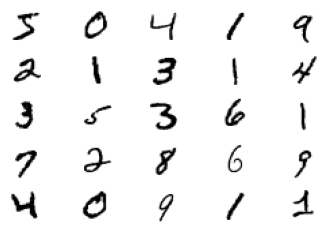

In [ ]:
import matplotlib.pyplot as plt

# plot images from the training dataset
def _plot(X):
	for i in range(25):
		# define subplot
		plt.subplot(5, 5, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(X[i].reshape(28, 28), cmap='gray_r')
	plt.show()
 
_plot(trainX[:25, :])

## 8.2. Discriminator

Chúng ta sẽ thiết kế Discriminator là một mạng CNN với layer Conv2D kết hợp xen kẽ với layer BatchNormalization. Stride và padding được kết hợp sao cho kích thước output shape của các layers thay đổi như sau: `(32, 32) -> Conv_s2 -> (16, 16) -> Conv_s2 -> (8, 8) -> Conv_s2 ->(4, 4) -> Conv_s2 ->(2, 2)`. Để hạn chế overfitting thì layer Dropout được áp dụng cuối mỗi block CNN. Một chú ý quan trọng đó là chúng ta bỏ `sigmoid activation` ở cuối cùng mà thay vào đó sử dụng `linear activation`.

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, LeakyReLU, \
Input, ZeroPadding2D, Flatten, Dense, \
UpSampling2D, Reshape, Cropping2D, Activation

def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

In [ ]:
from tensorflow.keras.models import Model

def get_discriminator_model():
    img_input = Input(shape=IMG_SHAPE)
    # Zero pad input để chuyển về kích thước (32, 32, 1).
    x = ZeroPadding2D((2, 2))(img_input) # --> (32, 32)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    ) # --> (16, 16)
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    ) # --> (8, 8)
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )  # --> (4, 4)
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )  # --> (2, 2)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    # Bỏ sigmoid activation function và thay bằng linear activation
    x = Dense(1, activation='linear')(x)

    d_model = Model(img_input, x, name="discriminator")
    return d_model


IMG_SHAPE = (28, 28, 1)
d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)       

## 8.3. Generator

Đầu vào của Generator là một véc tơ noise ngẫu nhiên có kích thước là 128. Sau đó đi qua các fully connected layer (hay còn gọi là dense layer) để tăng chiều dữ liệu và reshape về kích thước tensor3D với shape là (4, 4). Sử dụng layer Upsampling2D để tăng kích thước ảnh lên gấp đôi sau mỗi layer. Ngoài sử dụng Upsampling2D, chúng ta cũng có thể sử dụng tích chập chuyển vị [Conv2DTranspose](https://phamdinhkhanh.github.io/2020/06/10/ImageSegmention.html#7-t%C3%ADch-ch%E1%BA%ADp-chuy%E1%BB%83n-v%E1%BB%8B-transposed-convolution) cũng có tác dụng tăng kích thước layers. Chuỗi kích thước layers của chúng ta sẽ theo thứ tự: `(4, 4) -> Upsampling_s2 -> (8, 8) -> Upsampling_s2 -> (16, 16) -> Upsampling_s2 ->(32, 32)`. Output shape cuối cùng sẽ bằng với kích thước của ảnh gốc.

Ngoài ra hàm activation là hàm `tanh` được áp dụng phía sau layer cuối cùng để chuẩn hóa giá trị output về khoảng $[-1, 1]$.


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, LeakyReLU, Input, ZeroPadding2D, Flatten, Dense, UpSampling2D, Reshape, Cropping2D, Activation
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

def get_generator_model():
    noise = Input(shape=(noise_dim,))
    x = Dense(4 * 4 * 256, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # Crop ảnh về kích thước (28, 28, 1)
    x = Cropping2D((2, 2))(x)

    g_model = Model(noise, x, name="generator")
    return g_model

noise_dim = 128
g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         29

## 8.4. WGAN-GP model

Ở bước này chúng ta sẽ khởi tạo mô hình WGAN-GP. Để huấn luyện mô hình WGAN-GP thì chúng ta sẽ cần khai báo generator, discriminator và các hàm loss function của generator và discriminator. Hàm quan trọng nhất của WGAN-GP là hàm `train_step()` sẽ có tác dụng huấn luyện trên từng batch. Ở hàm này chúng ta sẽ thực hiện các bước:

1. Lấy mẫu ngẫu nhiên ảnh real và ảnh fake. Trong đó ảnh real được lựa chọn từ mô hình và ảnh fake được tạo ra từ generator từ một véc tơ ngẫu nhiên.
2. Tính toán phạt cho gradient dựa trên chênh lệch giữa ảnh real và ảnh fake. Gradient được lấy trong bối cảnh của hàm `tf.GradientTape()`.
3. Nhân phạt của gradient với một giá trị hệ số alpha.
4. Tính loss function cho discirminator
5. Thêm phạt gradient vào loss function của discriminator
6. Cập nhật gradient theo loss function của discriminator và generator thông qua hàm `tape.apply_gradients()`





In [ ]:
import tensorflow as tf

class WGAN(Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """
        Tính toán phạt cho gradient
        hàm loss này được tính toán trên ảnh interpolated và được thêm vào discriminator loss
        """
        # tạo interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. dự đoán discriminator output cho interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Tính gradients cho interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Tính norm của gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]

        # Với mỗi một batch chúng ta sẽ thực hiện những bước sau
        # following steps as laid out in the original paper.
        # 1. Lấy mẫu ngẫu nhiên ảnh real và ảnh fake. Trong đó ảnh real được lựa chọn từ mô hình và ảnh fake được tạo ra từ generator từ một véc tơ ngẫu nhiên.
        # 2. Tính toán phạt cho gradient dựa trên chênh lệch giữa ảnh real và ảnh fake. Gradient được lấy trong bối cảnh của hàm `tf.GradientTape()`.
        # 3. Nhân phạt của gradient với một giá trị hệ số alpha.
        # 4. Tính loss function cho discirminator
        # 5. Thêm phạt gradient vào loss function của discriminator
        # 6. Cập nhật gradient theo loss function của discriminator và generator thông qua hàm `tape.apply_gradients()`
        # Chúng ta sẽ huấn luyện discrimnator với d_steps trước. và sau đó chúng ta mới huấn luyện generator. 
        # Như vậy cùng một batch thì discriminator được huấn luyện gấp d_steps lần so với generator.
        
        for i in range(self.d_steps):
            # Khởi tạo latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            # Chúng ta phải thực thi trong tf.GradientTap() để lấy được giá trị gradient.
            with tf.GradientTape() as tape:
                # Tạo ảnh fake từ latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Dự báo điểm cho ảnh fake
                fake_logits = self.discriminator(fake_images, training=True)
                # Dự báo điểm cho ảnh real
                real_logits = self.discriminator(real_images, training=True)

                # Tính discriminator loss từ ảnh real và ảnh fake
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Tính phạt gradient
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Thêm phạt gradient cho discriminator loss ban đầu
                d_loss = d_cost + gp * self.gp_weight

            # Lấy gradient của discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            
            # Cập nhật weights của discriminator sử dụng discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Huấn luyện generator
        # Khởi tạo véc tơ latent
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Tạo ảnh fake từ generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            # Dự báo điểm cho ảnh fake từ discriminator
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Tính generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Lấy gradient cho generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Cập nhật hệ số của generator sử dụng generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

## 8.5. GAN monitoring

GANMonitoring là một Callback được gọi mỗi khi kết thúc một epoch để  kiểm tra kết quả dự báo của một số ảnh sau mỗi epoch huấn luyện của mô hình.

In [ ]:
from tensorflow.keras.callbacks import Callback
class GANMonitor(Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = tf.keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

## 8.6. Huấn luyện







In [ ]:
from tensorflow.keras.optimizers import Adam
# Khởi tạo optimizer
# learning_rate=0.0002, beta_1=0.5 được khuyến nghị
generator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function

# Xác định loss functions được sử dụng cho discriminator. = (fake_loss - real_loss).
# Ở hàm train_step của WGAN chúng ta phải thêm phạt gradient penalty cho hàm này.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Xác định loss function cho generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Khởi thạo tham số và mô hình

epochs = 20

# Callbacks
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

BATCH_SIZE = 512
# Huấn luyện
wgan.fit(trainX, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/20
118/118 [==============================] - 452s 4s/step - d_loss: -16.4176 - g_loss: -18.2579
Epoch 2/20
118/118 [==============================] - 451s 4s/step - d_loss: -14.8740 - g_loss: -10.5063
Epoch 3/20
118/118 [==============================] - 451s 4s/step - d_loss: -13.6230 - g_loss: -7.1806
Epoch 4/20
118/118 [==============================] - 451s 4s/step - d_loss: -12.4002 - g_loss: -6.0320
Epoch 5/20
118/118 [==============================] - 451s 4s/step - d_loss: -11.3737 - g_loss: -4.8758
Epoch 6/20
118/118 [==============================] - 450s 4s/step - d_loss: -10.3618 - g_loss: -2.2818
Epoch 7/20
118/118 [==============================] - 451s 4s/step - d_loss: -9.5416 - g_loss: 1.5632
Epoch 8/20
118/118 [==============================] - 451s 4s/step - d_loss: -8.7864 - g_loss: 3.9821
Epoch 9/20
118/118 [==============================] - 450s 4s/step - d_loss: -8.1304 - g_loss: 5.6272
Epoch 10/20
118/118 [==============================] - 450s 4s/step 

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive/')
os.chdir('gdrive/My Drive/Colab Notebooks/GAN')

In [ ]:
!mkdir wgan
g_model.save('wgan/generator.h5')
d_model.save('wgan/discriminator.h5')

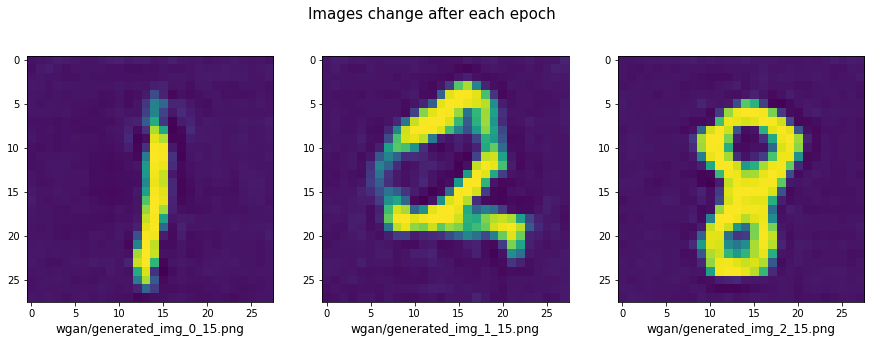

In [ ]:
import matplotlib.pyplot as plt

images = ["wgan/generated_img_0_15.png", "wgan/generated_img_1_15.png", "wgan/generated_img_2_15.png"]
fg, ax = plt.subplots(1, 3, figsize=(15, 5))
fg.suptitle('Images change after each epoch', fontsize=15)

for i in np.arange(3):
  X = plt.imread(images[i])
  ax[i].imshow(X)
  ax[i].set_xlabel(images[i], fontsize=12)

# 9. Tài liệu

1. [GAN wasserstein and GAN wasserstein GP - jonathan_hui](https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)
2. [GAN spectral normalization - jonathan_hui](https://medium.com/@jonathan_hui/gan-spectral-normalization-893b6a4e8f53)
3. [wasserstein GAN - vincentherrmann](https://vincentherrmann.github.io/blog/wasserstein/)
4. [How to implement wasserstein loss for GAN - machinelearningmastery](https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/)
5. [How to code a wasserstein GAN from scratch - machinelearningmastery](https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/)
